In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.01
m1 = 0.
s0 = 0.5
dim = [1,2]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

k = dim[0] * dim[1]
with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([Linear(dim=k*(k-1)//2 + k, name='lowerd_flow')])
#     ldiag = DFlow([Linear(dim=k, name='ldiag_flow')])
    lowerd = DFlow([Linear(dim=k*(k-1)//2 + k, name='lowerd_flow')])
    ldiag = DFlow([NVPFlow(dim=k, name='lowerd_flow_' + str(i)) for i in range(4)])
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
                   lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))

In [3]:
params.shape

(32, 1, 2)

In [4]:
def autoregr(X, param):
    d = param[:,:dim[-1]-1]
    X = np.matmul(X, d) + param[:,-1][np.newaxis] + np.random.normal(size=[1,dim[-1]-1], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [5]:
xs = [np.random.normal(size=[1,dim[0]])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.concatenate(xs)[np.newaxis].astype(floatX)

In [6]:
xs[:,:6]

array([[[ 1.03380073],
        [-0.5918482 ],
        [-0.54354248],
        [-0.83599905],
        [-0.78511876],
        [-0.74559205]]])

In [7]:
xs.shape

(1, 32, 1)

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([NVPFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(6)], init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1], init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice_2:0' shape=(1, 32, 2) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][np.newaxis], out[i])
        ll += obs_d.logdens(pred)
    return ll

def create_loglik2():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
df = dim[0]*dim[1]*20
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [18]:
loss = -logl - prior + ent - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [19]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [20]:
sess = tf.InteractiveSession()

In [21]:
tf.global_variables_initializer().run()

In [22]:
prior.eval(), ent.eval(), logl.eval()

(72.04715589320665, 198.59541496404748, -5600.321869174953)

In [23]:
loss.eval()

array([89.9999944])

In [24]:
np.set_printoptions(precision=4)

In [25]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 1.4166e+04, -1.7860e+01],
       [-1.7860e+01,  5.8306e+04]])

In [44]:
%%time
for _ in range(5000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')

[0.3784]
[[2377151.6432    5292.6799]
 [   5292.6799 1621232.4133]]




KeyboardInterrupt: 

In [45]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval()[:3,:3])
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

In [46]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.0007, 0.0007]), array([6.4268e-05, 5.7847e-05]))

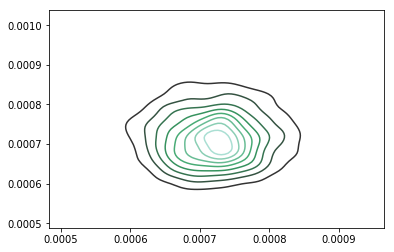

In [47]:
sns.kdeplot(ss[:,1], ss[:,0])
plt.show()

In [30]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [48]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [49]:
samples.shape

(1000, 32, 1, 2)

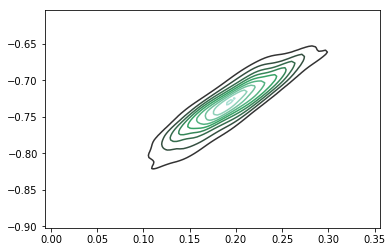

In [54]:
sns.kdeplot(samples[:,0,0,0], samples[:,0,0,1])
plt.show()

In [55]:
t = 18
params[t]

array([[ 0.3209, -0.6453]])

In [56]:
np.mean(samples[:,t], axis=0)

array([[ 0.1927, -0.7359]])